<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeAutomatizado/blob/2022-2/notebooks/1b_clasificador_bayesiano_bernoulli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador bayesiano ingenuo de Bernoulli
En esta libreta programaremos un clasificador bayesiano ingenuo en el cual se presupone que la distribución de los atributos dada la clase es una Bernoulli y hay dos posibles clases. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.naive_bayes import BernoulliNB as SKBNB
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

## Carga de datos

El conjunto de entrenamiento consiste de 11 documentos que pertenecen a las clases de deportes (0) o informática (1). Cada documento es un vector de 8 dimensiones donde cada dimensión representa la frecuencia de las palabras en nuestro vocabulario de interés:
 
$$V =
      \begin{vmatrix}
      w_1 = gol & w_2 = computación & w_3 = transmitir & w_4= velocidad\\
      w_5 = \textit{técnica} & w_6= defensa & w_7=\textit{desempeño} & w_8=campo \\
      \end{vmatrix}  
 $$
 
 Lectura con Pandas:

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/gibranfp/CursoAprendizajeAutomatizado/master/data/dep_inf.csv')
df

,w1,w2,w3,w4,w5,w6,w7,w8,c
0,2,0,0,0,1,2,3,1,0
1,0,0,1,0,2,1,0,0,0
2,0,1,0,1,0,2,1,0,0
3,1,0,0,2,0,1,0,1,0
4,2,0,0,0,1,0,1,3,0
5,0,0,1,2,0,0,2,1,0
6,0,1,1,0,0,0,1,0,1
7,1,2,0,1,0,0,1,1,1
8,0,1,1,0,0,2,0,0,1
9,0,0,0,0,0,0,0,0,1


Conversion a numpy:

In [3]:
data = df.to_numpy()

## Clasificador bayesiano ingenuo para distribución de Bernoulli
Definimos una función para obtener la probabilidad de 0 o 1 dada una distribución de Bernoulli con parámetro $q$.

In [4]:
def bernoulli(x, q):
    """
    Distribución de bernoulli
    """
    return np.power(q, x) * np.power(1.0 - q, 1.0 - x)

Definimos una clase con el clasificador bayesiano ingenuo para atributos binarios y estimación de parámetros por máxima verosimilitud.

In [5]:
np.power([0.2, 0.3, 0.4], [[0, 1, 2], [3,4,5]])

array([[1.     , 0.3    , 0.16   ],
       [0.008  , 0.0081 , 0.01024]])

In [6]:
class BernoulliNB:
  def fit(self, X, y):
    """
    Estima parámetros por máxima verosimilitud
    """
    self.clases = np.unique(y)
    self.n_clases = self.clases.size
    self.n_atr = X.shape[-1]
    self.qa = np.zeros((self.n_clases, self.n_atr))
    self.qc = np.zeros((self.n_clases))

    n = X.shape[0]
    for i,c in enumerate(self.clases):
      Xc = X[np.where(y == c)]
      nc = Xc.shape[0]
      self.qc[i] = nc / n
      cuentas = np.count_nonzero(Xc, axis = 0)
      self.qa[i, :] = cuentas / nc

  def predict_proba(self, x):
    """
    Calcula a posteriori (proporcional) de conjunto de datos
    """
    prop = np.zeros((x.shape[0], self.n_clases))
    for i in range(self.n_clases):
      prop[:, i] = np.prod(bernoulli(x, self.qa[i, :]), axis=1) * self.qc[i]
    
    return prop

  def predict(self, x):
    """
    Predice clase de conjunto de datos
    """
    return np.argmax(self.predict_proba(x), axis=1)

X_ent = data[:, :-1]
y_ent = data[:, -1]
X_nuevos = np.array([[1, 0, 0, 1, 1, 1, 0, 1], [0, 1, 1, 0, 1, 0, 1, 0]])

bnb = BernoulliNB()
bnb.fit(X_ent, y_ent)

y_bnb = bnb.predict(X_nuevos)
p_bnb = bnb.predict_proba(X_nuevos)

print(y_bnb)
print(p_bnb)

[0 1]
[[5.61167228e-03 9.30909091e-06]
 [2.80583614e-04 8.04305455e-03]]


El método `predict_proba` calcula

$$
P(\mathbf{x} \vert y)\cdot P(y) \propto P(y \vert \mathbf{x})
$$

Para obtener la probabilidad a posteriori es necesario dividir este valor entre 
$$
P(\mathbf{x}) = \sum_c P(\mathbf{x}, y = c) = \sum_c P(\mathbf{x} \vert y = c) P(y = c)
$$ 

In [7]:
print(np.sum((p_bnb / np.sum(p_bnb, axis=0)), axis=0))

[1. 1.]


Cuando el número de atributos es muy grandes, es conveniente usar escala logarítmica para calcular la probabilidad de las clases dado un nuevo dato.

In [8]:
class BernoulliNBLog:
  def fit(self, X, y):
    """
    Estima parámetros por máxima verosimilitud
    """
    self.clases = np.unique(y)
    self.n_clases = self.clases.size
    self.n_atr = X.shape[-1]
    self.qa = np.zeros((self.n_clases, self.n_atr))
    self.qc = np.zeros((self.n_clases))

    n = X.shape[0]
    for i,c in enumerate(self.clases):
      Xc = X[np.where(y == c)]
      nc = Xc.shape[0]
      self.qc[i] = nc / n
      cuentas = np.count_nonzero(Xc, axis = 0)
      self.qa[i, :] = cuentas / nc
  
  def predict_proba(self, x):
    """
    Calcula a posteriori de conjunto de datos
    """
    prop = np.zeros((x.shape[0], self.n_clases))
    for i in range(self.n_clases):
      a0log = (1 - x) @ np.log(1 - self.qa[i, :])
      a1log = x @ np.log(self.qa[i, :])
      prop[:, i] = a0log + a1log + np.log(self.qc[i])
    
    return prop

  def predict(self, x):
    """
    Predice clase de conjunto de datos
    """
    return np.argmax(self.predict_proba(x), axis=1)

bnbl = BernoulliNBLog()
bnbl.fit(X_ent, y_ent)

y_bnbl = bnbl.predict(X_nuevos)
p_bnbl = bnbl.predict_proba(X_nuevos)

print(y_bnb)
print(p_bnbl)
print(np.exp(p_bnbl))
print(np.exp(p_bnbl) / np.sum(np.exp(p_bnbl), axis=0))

[0 1]
[[ -5.18290652 -11.58451912]
 [ -8.17863879  -4.82294635]]
[[5.61167228e-03 9.30909091e-06]
 [2.80583614e-04 8.04305455e-03]]
[[0.95238095 0.00115607]
 [0.04761905 0.99884393]]


Podemos modificar la definición anterior para estimar los parámetros por máximo a posteriori.

In [9]:
class BernoulliNBLogMAP:
  def fit(self, X, y, alfa=2):
    """
    Estima parámetros por máxima verosimilitud
    """
    self.clases = np.unique(y)
    self.n_clases = self.clases.size
    self.n_atr = X.shape[-1]
    self.qa = np.zeros((self.n_clases, self.n_atr))
    self.qc = np.zeros((self.n_clases))

    n = X.shape[0]
    for i,c in enumerate(self.clases):
      Xc = X[np.where(y == c)]
      nc = Xc.shape[0]
      # Misma alfa para todas las categorías
      self.qc[i] = (nc + alfa - 1) / (n + alfa * self.n_clases - self.n_clases) 
      cuentas = np.count_nonzero(Xc, axis = 0)
      self.qa[i, :] = (cuentas + alfa - 1) / (nc + self.n_atr + alfa - 2) 

  def predict_proba(self, x):
    """
    Calcula a posteriori de conjunto de datos
    """
    prop = np.zeros((x.shape[0], self.n_clases))
    for i in range(self.n_clases):
      a0log = (1 - x) @ np.log(1 - self.qa[i, :])
      a1log = x @ np.log(self.qa[i, :])
      prop[:, i] = a0log + a1log + np.log(self.qc[i])
    
    return prop

  def predict(self, x):
    """
    Predice clase de conjunto de datos
    """
    return np.argmax(self.predict_proba(x), axis=1)

bnblm = BernoulliNBLogMAP()
bnblm.fit(X_ent, y_ent)

y_bnblm = bnblm.predict(X_nuevos)
p_bnblm = bnblm.predict_proba(X_nuevos)

print(y_bnblm)
print(p_bnblm)
print(np.exp(p_bnblm))
print(np.exp(p_bnblm) / np.sum(np.exp(p_bnblm), axis=0))

[0 1]
[[ -7.27371244 -11.23537511]
 [ -7.94438676  -6.84917339]]
[[6.93532513e-04 1.31989258e-05]
 [3.54647308e-04 1.06033181e-03]]
[[0.66165414 0.01229487]
 [0.33834586 0.98770513]]


## Clasificación de documentos por tema
Probaremos nuestro clasificador bayesiano ingenuo en la clasificación de documentos por tema usando el conjunto de datos _20 newsgroups_.

In [10]:
ng_ent = fetch_20newsgroups(subset='train', 
                            shuffle=True, 
                            random_state=42)

ng_prueba = fetch_20newsgroups(subset='test',
                               shuffle=True, 
                               random_state=42)

Obtenemos la representación vectorizada binaria. 

In [11]:
vec = CountVectorizer(max_features=10000,
                      stop_words='english', 
                      binary=True)

X_ent = vec.fit_transform(ng_ent.data)
y_ent = ng_ent.target

X_prueba = vec.transform(ng_prueba.data)
y_prueba = ng_prueba.target

Veamos cómo están distribuidas las clases en el conjunto de entrenamiento

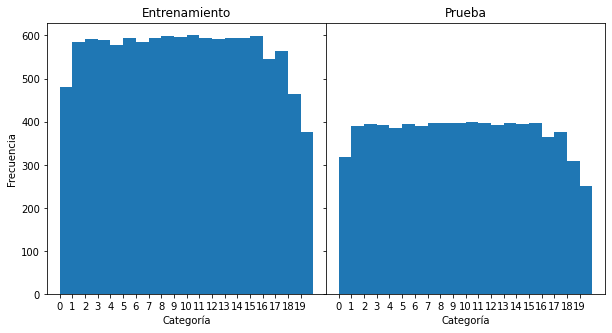

In [12]:
f,axs = plt.subplots(1,2, figsize=(10,5), sharey=True)

axs[0].hist(y_ent, bins=[i for i in range(21)])
axs[0].set_xticks(np.unique(y_ent))
axs[0].set_xlabel(u'Categoría')
axs[0].set_xlabel(u'Categoría')
axs[0].set_ylabel('Frecuencia')
axs[0].set_title(u'Entrenamiento')

axs[1].hist(y_prueba, bins=[i for i in range(21)])
axs[1].set_xticks(np.unique(y_prueba))
axs[1].set_xlabel(u'Categoría')
axs[1].set_title(u'Prueba')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

En `scikit-learn` dentro del submódulo `naive_bayes` están definidos clasificadores bayesianos ingenuos con distintas distribuciones para los atributos. Compararemos nuestro clasificador con el `BernoulliNB` de `scikit-learn` para distintos tamaños de vocabulario.

In [13]:
tam = np.arange(2000, 22000, 2000)
exac_nt = []
exac_sk = []
for t in tam:
  vec = CountVectorizer(max_features=t,
                      stop_words='english', 
                      binary=True)

  X_ent = vec.fit_transform(ng_ent.data)
  y_ent = ng_ent.target

  X_prueba = vec.transform(ng_prueba.data)
  y_prueba = ng_prueba.target

  clasificador = BernoulliNBLogMAP()
  clasificador.fit(X_ent.toarray(), y_ent)
  pred = clasificador.predict(X_prueba.toarray())
  exactitud = (pred==y_prueba).mean()
  exac_nt.append(exactitud)
  print('Exactitud = {0}'.format(exactitud))

Exactitud = 0.6299787573021773
Exactitud = 0.6763143919277749
Exactitud = 0.7044609665427509
Exactitud = 0.7156133828996283
Exactitud = 0.7259691980881572
Exactitud = 0.733935209771641
Exactitud = 0.7405735528412108
Exactitud = 0.7453531598513011
Exactitud = 0.7480084970791291
Exactitud = 0.7485395645246946


Graficamos el rendimiento con respecto al tamaño del vocabulario.

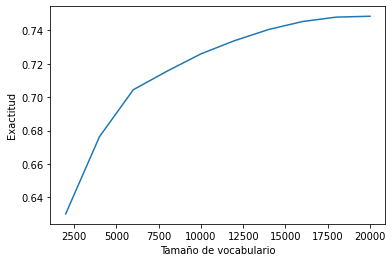

In [14]:
plt.plot(tam, exac_nt)
plt.xlabel(u'Tamaño de vocabulario')
plt.ylabel(u'Exactitud')
plt.show()